In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run fix_paths.ipy

/home/femianjc/Projects/srp-boxes


In [2]:
from srp.config import C

In [3]:
C.TRAIN.CLASS_BALANCE

[1.0, 1.0]

In [4]:
C.TRAIN.BATCH_SIZE=8  # I am on a laptop -- not much RAM(!)

In [5]:
import logging; logging.getLogger().setLevel(logging.INFO)

In [6]:
from srp.util import tqdm

In [7]:
from srp.model.rgblidar_dataset import RgbLidarDataset

In [8]:
from srp.model.arch import Solver, Architecture

In [9]:
from srp.data.orientedboundingbox import OrientedBoundingBox

In [10]:
import torch
import torch.nn
import torch.utils.data

In [11]:
import numpy as np

In [12]:
from math import ceil, sqrt

In [13]:
import matplotlib.pyplot as plt

In [14]:
# %run srp/data/generate_csv.py

In [15]:
# %run srp/data/generate_patches.py

In [16]:
# %run srp/data/generate_variations.py

In [17]:
# %run srp/data/train_val_split.py

In [18]:
training_data = RgbLidarDataset('train')

In [19]:
eval_data = RgbLidarDataset('test')

In [20]:
def make_stratified_sampler(dataset, target_ratio, num_samples = None):
    """Generate a sampler that will balance the labels. 
    
    Parameters
    ----------
    dataset: An RgbLidar dataset that yields (x,y) where y=(label, params)
    target_ratio: The desired ration of neative and positive samples; As a list [num_neg, num_pos]
    num_samples: The size of the resampled dataeset; default stays he same size. 
    
    Returns
    -------
    sampler (WeightedRandomSampler):A pytorch sampler that acheives the target rations.
    
    """
    labels = []
    for i, (x, y) in enumerate(tqdm(dataset, desc='Counting labels')):
        classlabel, params = y
        labels.append(classlabel)
    num_pos = sum(labels)
    num_neg = len(labels) - num_pos

    if num_samples is None:
        num_samples = len(training_data)
    
    # The _negative_ weight is proportional to the number of _non-negative_ samples. And vice-versa.
    class_weights = np.array([num_pos, num_neg])/max([num_neg, num_pos])
    class_weights *= C.TRAIN.CLASS_BALANCE
    sample_weights = class_weights[labels]
    return torch.utils.data.sampler.WeightedRandomSampler(sample_weights, num_samples=num_samples)

In [21]:
train_sampler = make_stratified_sampler(training_data, C.TRAIN.CLASS_BALANCE)
eval_sampler = make_stratified_sampler(eval_data, C.TRAIN.CLASS_BALANCE)

In [22]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=C.TRAIN.BATCH_SIZE, sampler=train_sampler)
eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=C.TRAIN.BATCH_SIZE, sampler=eval_sampler)

In [23]:
x, (y, params) = batch = iter(eval_loader).next()

In [24]:
x.type()

'torch.FloatTensor'

In [25]:
y.type()

'torch.LongTensor'

In [26]:
params.type()

'torch.FloatTensor'

In [27]:
from srp.visualize.plots import plot_batch

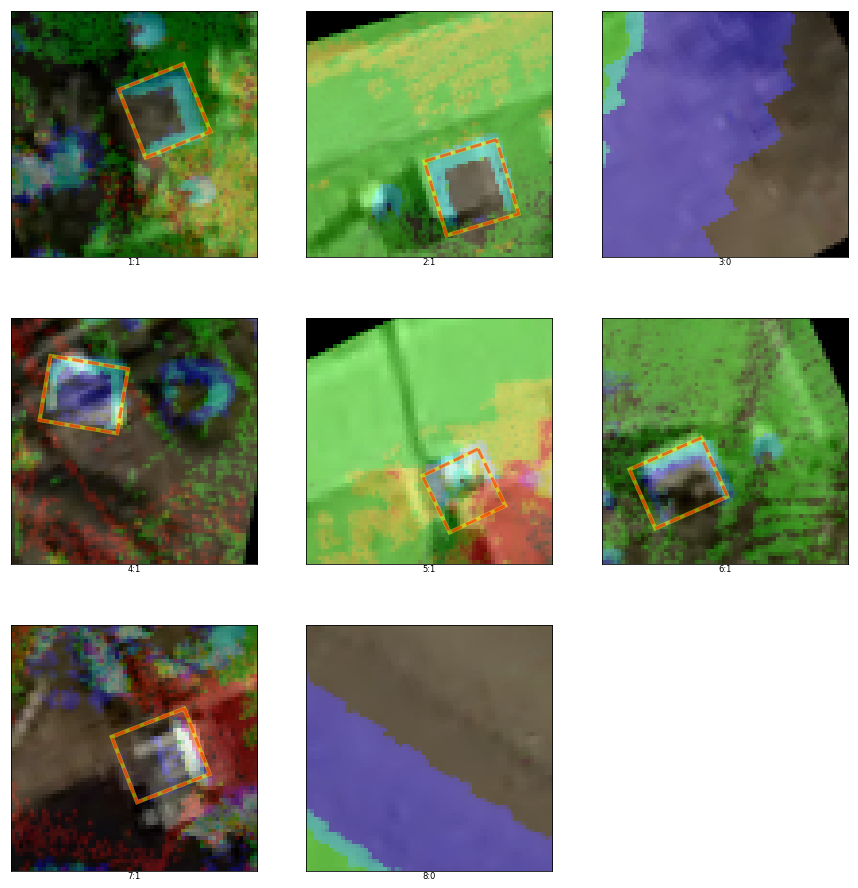

In [33]:
plt.figure(figsize=(15,16))
plot_batch(batch, min(len(batch[0]), 16), alpha=0.4)

In [34]:
arch =Architecture()

In [35]:
solver = Solver(trn_loader=train_loader, val_loader=eval_loader, net=arch)

In [36]:
solver.iterate()

In [39]:
solver.train()

epoch     1 trn_loss=  nan val_loss=  5.5 F_2= 64.2%  accuracy= 65.2%  precision= 100.0%  recall= 58.9%
epoch     2 trn_loss=  5.2 val_loss=  4.6 F_2= 62.5%  accuracy= 61.3%  precision= 100.0%  recall= 57.2%


PicklingError: Can't pickle <class 'srp.model.arch.EvaluationData'>: it's not the same object as srp.model.arch.EvaluationData